<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/WorkCAP2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/HackathonWorCap/images/blob/main/banner2.001.jpeg?raw=true">

<h2 style="text-align:center">
Instituto Nacional de Pesquisas Espaciais, INPE <br>
Pós-Graduação em Computação Aplicada, CAP <br>
Workshop de Computação Aplicada, WorCAP <br>
Hackathon 2022
</h2>

<h1 style="text-align:center">Machine Learning Aplicada para Processamento de Imagens de Sensoriamento Remoto</h1>

# 1. Introdução 
<hr style="border:1px solid #7D26CD"> 
<p style="text-align:justify"> 
Este notebook reune vários tópicos indispensáveis que servirão de apoio para o desenvolvimento do seu projeto. Por isso, prezado leitor, devo lembrá-lo de mais alguns pontos antes de iniciarmos, i) Você poderá executar seu projeto em sua máquina pessoal, Google Colab, ou Kaggle, conquanto que a versão final seja submetida aqui no local do desafio; ii) Disponibilize seu código na plataforma a partir do dia 12 de setembro, para que outros grupos vejam sua solução; iii) Serão aceitos notebooks nos idiomas Português, Espanhol, ou Inglês; iv) Atente-se ao formato de arquivo exigido no processo de envio dos resultados; e v) Serão aceitas submissões de equipes ou individuais daqueles inscritos no evento WorCAP 2022.
</p>

## 1.1 Primeiros passos

<p style="text-align:justify">
Inicialmente faça uma cópia do notebook. Após, inicie uma sessão clicando no botão <i>Power</i>, também verifique em <i>Settings</i> se a linguagem selecionada é Python e o <i>Accelerator</i> está marcado em GPU. Relação a <i>Data</i>, faça a importação do conjunto de dados em clicando em seta para baixo, tenha certeza de que na área de <i>Input</i> o dataset "hackathon-worcap-2022" está disponível, caso contrário, clique em <i>Add data</i>, em seguida <i>Upload</i>. Tudo pronto? Agora, mão na massa! ✌🏼😃
</p>

# 2. Hands on
<hr style="border:1px solid #7D26CD"> 

<p style="text-align:justify">
Antes de preparar a massa é preciso reuniri os materiais, certo? Por isso, na célula abaixo fazemos a importação dos pacotes, APIs e frameworks:
</p>

In [1]:
# Diretório
import os, sys
from glob import glob
import glob

# Dados
import imgaug as ia
import imgaug.augmenters as iaa
import random 
import PIL
from PIL import Image
from PIL import ImageOps
import skimage
import skimage.io as skio
import numpy as np

import pandas as pd
from tensorflow.keras.preprocessing import image

# Machine Learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

# Gráficos
import matplotlib.pyplot as plt

In [4]:
#Monting Google Drive
#https://medium.com/analyatics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
#!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#!kaggle datasets download -d grupohackaton2022/hackathon-notebook -p /content/

!kaggle competitions download -c hackathon-worcap-2022 -p /content/
#Unziping data-set
!unzip "hackathon-worcap-2022.zip" -d "/content/"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3539.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3548.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3549.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3558.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3559.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3560.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3561.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3562.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3563.tif  
  inflating: /content/dataset_participants/train/TCC2020_CBERS4A/TCC2020_CBERS4A_3564.tif  
  inflating: /content

## 2.1 Dataset
<p style="text-align:justify">
O dataset contém dois subconjuntos de imagens. O primeiro <b>train</b> inclui dois outros subconjuntos: <b>CBERS4A_WPM_L4_RGB</b>, contém à 8162 patches; e <b>TCC2020_CBERS4A</b>, compreende 8162 labels,respectivamente para cada imagem. O segundo subconjunto, <b>test</b>, possui apenas um subdiretório <b>CBERS4A_WPM_L4_RGB</b> com 3502 patches. Todas as imagens estão em formato <b>.tif</b>, com informações geoespaciais preservadas, e proporções de <b>128,128,3</b>, ou seja, altura, largura, e quantidade de canais de cores. Para mais informações sobre o pré-processamento dos dados acesse a seção <b><a href="https://www.kaggle.com/competitions/hackathon-worcap-2022/data">Data</a></b>, do Desafio. 
</p>

<p style="text-align:justify">
Preparamos um setup, apresentado na célula abaixo, inclui constantes e listas declaradas, uma função de leitura de imagem e label (mask), bem como uma lib contento o ID e seu respectivo label e cor. 
</p>

In [15]:
# Setup:

# Constantes 
IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 3
IMAGE_SIZE = 128
NUM_CLASSES = 10
BATCH_SIZE = 64

# Variáveis
resultF1 = 0
overallF1 = 0
resultAcc = 0
overallAcc = 0

# Ajustes
m = tf.keras.metrics.Accuracy()

# Função para leitura dos files
def read_image(image_path, mask=False):
    # Recebe os caminhos dos files
    img = skio.imread(image_path)
    
    # Se for label a variável img receberá ela mesma
    if mask:
        # A imagem recebe apenas imagem
        img = img
    # Caso contrário, 
    else: 
        # se for patch o valores dos pixels é divido por 255
        img = img/255
    # A função retorna a imagem 
    return img


# Paths Train e test
cbers_train = ['/content/dataset_participants/test/CBERS4A_WPM_L4_RGB','/content/dataset_participants/train/TCC2020_CBERS4A']
cbers_test = ['/content/dataset_participants/test/CBERS4A_WPM_L4_RGB']


# Classes e seus índices
lista_class = {'agr_perene':1,'agr_temp_1':2,'agr_temp_2mais':3,'agua_natural':4,'d2020':5,'florestal':6, 
               'mineracao':7,'urbanizada':8,'past_herbacea':9,'silvicultura':10}


# Cores padrões para cada classe, seguindo a legenda do TerraClass
color_dict_lulc = {'agr_perene':'#f98a28','agr_temp_1':'#f9e500','agr_temp_2mais':'#fffe00','agua_natural':'#0000ff',
                   'd2020':'#ff0000','florestal':'#0b5204','mineracao':'#ad89cd',
                   'urbanizada':'#ffa8c0','past_herbacea':'#d7ef89','silvicultura':'#dcdd0f'}


<p style="text-align:justify">
A seguir, os caminhos (path) das imagens de cada subconjunto são carregados para uma variável que, na sequência, são ordenados usando o comando <b>.sort()</b>. A partir disso, a função <b>read_image</b> é usada para ler cada file e armazenada uma variável.
</p>

### 2.1.1 Subconjunto de treinamento
**Organização:**

In [16]:
# Organização da lista de rasters
# Lista: armazenará os paths de cada patch
org_path_pacth1 = [] 

# Loop: Acessa o diretório [0] para ler o paths
for raster in glob.iglob(cbers_train[0]+'/*.tif'):
    # Armazena o paths na lista
    org_path_pacth1.append(raster)
# Ordena os strings dos paths
org_path_pacth1.sort()

# Organização da lista de labels
#Lista: armazenará os paths de cada patch
org_path_label1 = []
# Loop: Acessa o diretório [1] para ler o paths
for raster in glob.iglob(cbers_train[1]+'/*.tif'):
    # Armazena o paths na lista
    org_path_label1.append(raster)
# Ordena os strings dos paths
org_path_label1.sort()

**Leitura:**

In [17]:
# Leitura e armazenamentos dos raster
# Lista: Armazenará as imagens 
train_patch = []
# Loop: acessa cada path
for i in org_path_pacth1:
    # Leitura: chama a função de leitura
    imagem = read_image(i)
    # Armazena patches na lista
    train_patch.append(imagem)

# Leitura e armazenamentos dos labels
# Lista: Armazenará as imagens
train_label = []
# Loop: acessa cada path
for i in org_path_label1:
    # Leitura: chama a função de leitura
    mask = read_image(i, mask=True)
    # Armazena labels na lista
    train_label.append(mask)
    
# Transforma em array
train_patch = np.array(train_patch)
train_label = np.array(train_label)

# Substui o label -1 por 1
train_label = np.where(train_label > 0, train_label, 1)
print('Classes labels: ', np.unique(train_label))

Classes labels:  [ 1  2  3  4  5  6  7  8  9 10]


### 2.1.2 Subconjunto de Teste
**Organização:**

In [18]:
# Organização da lista de rasters
# Lista: armazenará os paths de cada patch 
org_path_pacth2 = []

# Loop: Acessa o diretório [0] para ler o paths
for raster in glob.iglob(cbers_test[0]+'/*.tif'):
    # Armazena path de cada patch 
    org_path_pacth2.append(raster)

# Ordena os strings dos paths
org_path_pacth2.sort()

**Leitura:**

In [19]:
# Leitura e armazenamentos dos labels
# Lista: Armazenará as imagens 
test_patch = []
# Loop: acessa cada path
for i in org_path_pacth2:
    # Leitura: chama a função de leitura
    imagem = read_image(i)
    #Armazena o patch na lista
    test_patch.append(imagem)
    
# Transforma em lista
test_patch = np.array(test_patch)

### 2.1.3 Visualização dos dados
<p style="text-align:justify">
    A seguir, apresento como imprimir as imagens usando o pacote <b>Matplotlib</b>. 
</p>

In [ ]:
train_label

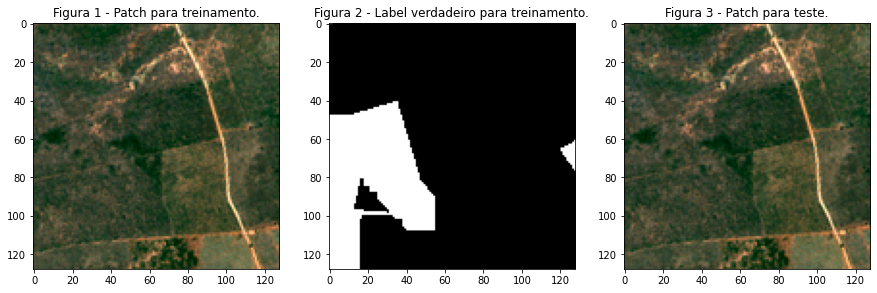

In [23]:
# 30, 271, 2772, 1933, 566, 1272, 2852, 2786, 1024
index = 31

# Faz Stack do label na intenção de aumentar a quantidade canais, de 1 para 3
yt = np.dstack((train_label[index],train_label[index],train_label[index]))

# Visualiza: Raster do subconjunto de treinamento
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(train_patch[index])
plt.title('Figura 1 - Patch para treinamento.')

# Visualiza: Label do subconjunto de teste
plt.subplot(132)
m1 = image.array_to_img(yt)
m1 = PIL.ImageOps.autocontrast(m1)
plt.imshow(m1)
plt.title('Figura 2 - Label verdadeiro para treinamento.')

# Visualiza: Raster do subconjunto de teste
plt.subplot(133)
plt.imshow(test_patch[index])
plt.title('Figura 3 - Patch para teste.')
plt.show()

### 2.1.4 Aumento de Dados
<p style="text-align:justify">
Na possibilidade aumentar a quantidade dados para treinamento, ou termo em inglês <i>Data Augmentation (DA)</i>, apresento-lhe algumas possibilidades de alterar a morfologia dos pathes e seus respectivos labels de treinamento usando as funcionalidades do pacote <a href="https://imgaug.readthedocs.io/en/latest/">imgaug</a>. Dessa forma, o DA pode melhorar o aprendizado, apresentando à rede neural mais representações sobre os dados, mas também atrapalhar se essas transformações forem demasiadamente divergentes dos dados reais.
</p>

In [24]:
# Variável recebe imagem
sample_patch = read_image(org_path_pacth1[index])

# Rotação
rotate = iaa.Affine(rotate=(-50, 30))
rotated_image = rotate.augment_image(sample_patch)

# Distorção
shear = iaa.Affine(shear=(0, 40))
shear_image = shear.augment_image(sample_patch)

# Flip horizontal
flip_hr = iaa.Fliplr(p=1.0)
flip_hr_image = flip_hr.augment_image(sample_patch)

# Flip vertical
flip_vr = iaa.Flipud(p=1.0)
flip_vr_image = flip_vr.augment_image(sample_patch)

# Não esqueça de salvar a imagem gerada
#Image.fromarray(rotated_image).save('name_file.tif')

<p style="text-align:justify">
O mais legal, entretanto, é a facilidade de combinar essas transformações e configurar seus parâmentros para gerar novas amostras de treinamento. Visualize a seguir os resultados das modificações aplicadas anteriormente:
</p>

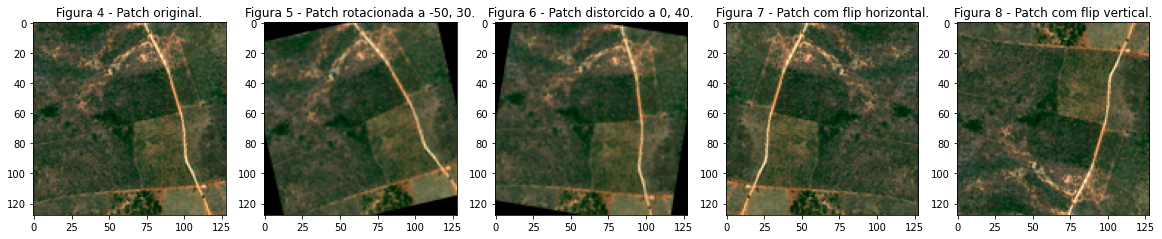

In [26]:
# Visualiza: Patch original
plt.figure(figsize=(20, 10))
plt.subplot(151)
plt.imshow(sample_patch)
plt.title('Figura 4 - Patch original.')

# Visualiza: Rotação
plt.subplot(152)
plt.imshow(rotated_image)
plt.title('Figura 5 - Patch rotacionada a -50, 30.')

# Visualiza: Distorção
plt.subplot(153)
plt.imshow(shear_image)
plt.title('Figura 6 - Patch distorcido a 0, 40.')

# Visualiza: Flip horizontal
plt.subplot(154)
plt.imshow(flip_hr_image)
plt.title('Figura 7 - Patch com flip horizontal.')

# Visualiza: Flip vertical
plt.subplot(155)
plt.imshow(flip_vr_image)
plt.title('Figura 8 - Patch com flip vertical.')

plt.show()

## 2.2 Deep Learning
<p style="text-align:justify">
O Aprendizado Profundo, conhecido também pelo termo inglês <i>Deep Learning</i> (DL), é um subconjunto de <i>Machine Learning</i> baseado em redes neurais artificiais, que por sua vez é um campo da Inteligência Artificial. As Redes Neurais de Aprendizado Profundo, portanto, se caracterizam pela arquitetura mais robusta, com várias camadas ocultas, cujos neurônios processam os features de entrada e geram novos features para os neurônios da camada seguinte, assim como possuem a capacidade de retropropagar os sinais de entrada de modo a atualizar seus pesos sinápticos <a href="https://docs.microsoft.com/pt-br/azure/machine-learning/concept-deep-learning-vs-machine-learning">(Microsoft, 2022)</a>. 
</p>   

<p style="text-align:justify"> 
No campo de visão computacional as <i>Convolutional Neural Networks</i> (CNN) são modelos de DL inspiradas no sistema visual humano, com capacidade de aprender características de baixo e alto nível <a href="https://www.deeplearningbook.org/contents/convnets.html">Goodfellow, Bengio e Courville (2016)</a>. Usualmente, as CNNs são implementadas para diversas tarefas tais como classificação, detecção de objetos e segmentação semântica, trabalhando com dados com várias dimensões (1D, 2D, e 3D).
</p>

<p style="text-align:justify">
Uma vez modeladas, tais redes são usualmente submetidas a um processo de treinamento, com o objetivo de que aprendam a desempenhar a tarefa designada. O processo em si é como o praticado por nós seres humanos: à rede é apresentada uma série de dados e exemplos para que possa aprender a lógica das relações de entrada e saída (bem como perguntas e respostas). No aprendizado supervisionado, o mais popular dos tipos de aprendizado, exitem basicamente duas etapas: treinamento e inferência (teste). E, tradicionalmente, existem três conjubtos de dados, obtidos por um processo de divisão (<i>splitting</i>). A Figura 9 a seguir mostra o conceito de <i>splitting</i>.
<br>
<h4>Figura 9 - Split do dataset.</h4>
<img src="https://miro.medium.com/max/1400/1*HEe_oHZHToY8oD1RoShHGg.png" width=800>
    
</p>


### 2.2.1 Modelos de Classificação Supervisionada
<p style="text-align:justify">
Neste desafio, você deverá usar um modelo CNN para a tarefa de segmentação semântica (classicação baseada em pixels) <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/pixel-classification.htm#:~:text=Semantic%20segmentation,%20also%20known%20as,or%20buildings%20from%20satellite%20imagery.">ArcGis</a>. A Classificação baseada em pixels consiste em segmentar a imagem em números de classes, ou seja, cada pixel recebe um rótulo de uma categoria, como ilustrado na Figura 10. No exemplo da figura, nota-se que cada classe recebe uma cor simbólica e um rótulo.
<br>
<br>
<h4>Figura 10 - Exemplo de Classificação baseada em Pixel.</h4>
<img src="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/GUID-8F670200-F052-4CC6-9590-0290916D256B-web.png" width=600>
    
</p>
<p style="text-align:justify">
Para este desafio sugerimos dois modelos de CNN: 

</p>

#### 2.2.1.1 U-Net
<p style="text-align:justify">
Este modelo foi proposto inicialmente por <a href="https://arxiv.org/pdf/1505.04597.pdf">Ronnenberger, Fischer e Brox (2015)</a>,  no artigo "<i>U-Net: Convolutional Networks for Biomedical Image Segmentation</i>", com o objetivo de classificar imagens de células. Contudo, tanto o modelo quanto a metodologias passaram a ser aplicadas para outras áreas, tal como a de Observação da Terra, no processamento de imagens de satélite.
</p>

<p style="text-align:justify">
A seguir veja alguns exemplos: <br>
    - <a href="https://github.com/vsantjr/DeepLearningMadeEasy/blob/temp_23-09/PyTorch_U-Net.ipynb">Deep Learning Made Easy</a>; <br>
    - <a href="https://keras.io/examples/vision/oxford_pets_image_segmentation/">Image segmentation with a U-Net-like architecture</a>; <br>
    - <a href="https://towardsdev.com/original-u-net-in-pytorch-ebe7bb705cc7/">Original U-Net in PyTorch</a>.
</p> 


#### 2.2.1.2 DeepLabv3+
<p style="text-align:justify">
Esta arquitetura, ao contrário da U-Net, possui <a href="https://towardsdatascience.com/a-primer-on-atrous-convolutions-and-depth-wise-separable-convolutions-443b106919f5">convolução atrous</a>, uma ferramenta poderosa para ajustar explicitamente o campo de visão do filtro, bem como controlar a resolução de respostas de recursos computadas por Deep Convolutional Neural Networks, na aplicação de segmentação semântica de imagens, proposta inicialmente por <a href="https://arxiv.org/abs/1606.00915">Chen, et al. (2016)</a>. Entretanto, DeepLabv3+, estendida de DeepLabv3, emprega uma estrutura de encoder-decoder, a qual codifica informações contextuais em várias escalas aplicando uma convolução atrosa em várias escalas, enquanto o módulo decodificador simples refina os resultados da segmentação ao longo dos limites do objeto <a href="https://arxiv.org/pdf/1802.02611.pdf">(Chen, et al, 2018)</a>. 
</p>
<p style="text-align:justify">
A seguir, veja alguns exemplos: <br>
    - <a href="https://keras.io/examples/vision/deeplabv3_plus/">Multiclass semantic segmentation using DeepLabV3+</a>; <br>
    - <a href="https://github.com/VainF/DeepLabV3Plus-Pytorch">DeepLabv3Plus-Pytorch</a>; <br>
    - <a href="https://github.com/Vignesh-95/cnn-semantic-segmentation-satellite-images">DeepLab: Deep Labelling for Semantic Image Segmentation</a>.
</p>

### 2.2.2 Analisando os resultados
<p style="text-align:justify">
    
Para avaliar o desempenho dos modelos usamos métricas que usam como parâmetros as saídas produzidas pelo modelo, predições e o resultados esperado. Para tanto, utilizaremos as métricas Accuracy e F1-Score. Geralmente, para realizar estes cálculos são utilizados os valores de verdadeiros e falsos positivos de forma binária. Quando há mais de duas classes, elas são discretizadas entre classes corretas e o verso dessas classes, tal como ilustrada na Figura 11: <b>Verdadeiro positivo (VP):</b> quantidade de discriminações corretas de classe; <b>Verdadeiro negativo (VN):</b> quantidade de discriminações corretas do verso de uma classe; <b>Falso positivo (FP):</b> quantidade de discriminações incorretas de uma classe; <b>Falso negativo (FN):</b> quantidade de discriminações incorretas do verso de uma classe.

<h4>Figura 11 - Matriz de confusão. Fonte: Sandra Avila</h4>
<img src="https://www.researchgate.net/profile/Sandra-Avila-5/publication/353340459/figure/fig1/AS:1078517265641473@1634149962531/Figura-1-Exemplo-de-matriz-de-confusao-para-classificadores-binarios.ppm" width=600>

</p> <br>

#### Acurácia
<p style="text-align:justify">
A acurácia é uma métrica que diz repeito à taxa de acertos em relação a todas as classificações. Segue a fórmula:
</p>

`accuracy = (VP + VN) / (VP + VN + FP + VN)`

#### Precisão
<p style="text-align:justify">
A precisão é uma métrica que diz respeito à taxa de verdadeiros positivos em relação à quantidade total de acertos, seguindo a fórmula:
</p>

`precision = VP / (VP + VN)`


#### Recorrência
<p style="text-align:justify">
A recorrência, também chamada de sensibilidade, é uma medida que diz respeito à taxa de discriminação de uma determinada classe em relação às demais (geralmente útil quando classificações de uma determinada classe não podem passar desapercebidas, mesmo se incorretas). Segue fórmula:
</p>

`recall = VP / (VP + FN)`


#### F1-Score
<p style="text-align:justify">
A pontuação F1 é geralmente descrita como uma média harmônica entre a precisão e recorrência, atuando como uma métrica sintética para a avaliação da rede neural. Segue a fórmula:
</p>

`F1 = 2 * (precision * recall) / (precision + recall)`

### 2.2.3 Teste de Performance
<p style="text-align:justify">
Depois de conhecer como funcionam as métricas de avaliação de performance de um Rede Neural Artificial, agora é hora de usá-las.  A célula abaixo exemplifica como você pode conduzir os testes de performance:
</p>

In [ ]:
# Predicão
#y_pred=model.predict(test_patch)

# Retorna os valores máximos dos índices no eixo 3
#y_pred_argmax=np.argmax(y_pred, axis=3)

# Altera o tipo de dado para int16
#y_pred_argmax = y_pred_argmax.astype('int16')

É importante destacar a importância de se transformar as matrizes em listas, usando o comando `list()` combinado com `flatten()` do pacote `numpy`. 

In [ ]:
# F1-Score: 
#f1 = f1_score(list(y_true.flatten()), list(y_pred_argmax.flatten()), average='weighted')
#print("F1-Score: ", f1)

# Accuracy:
#m.update_state(list(y_true.flatten()), list(y_pred_argmax.flatten()))
#acc = m.result().numpy()
#print("Accuracy: ", acc)

### 2.2.4 Submissão dos Resultados
<p style="text-align:justify">
Os resultados de submissão devem estar salvo em formato <b>.csv</b>. Para isso, faça:
</p>

In [ ]:
# Definie o nome das colunas do data frame
#colunas_list = ['id', 'label']

# Configura o tipo de dado para coluna ID
#column_type = {'id': str}

# Transforma as matrizes em listas
#list_ytrue = list(test_label.flatten())
#list_ypred = list(y_pred_argmax.flatten())

# Transforma lista em Dataframe
#resultTrue = pd.DataFrame(np.array([np.arange(len(list_ytrue)), list_ytrue]).T, columns=colunas_list)

# Altera tipo do dado da coluna ID
#resultTrue = resultTrue.astype(column_type)

# Salva em formato .csv
#resultTrue.to_csv('ytrue.csv', index=False)

# Transforma lista em Dataframe
#resultPred = pd.DataFrame(np.array([np.arange(len(list_ypred)), list_ypred]).T, columns=colunas_list)

# Altera tipo do dado da coluna ID
#resultPred = resultPred.astype(column_type)

# Salva em formato .csv
#resultPred.to_csv('ypred.csv', index=False)

<p style="text-align:justify">
Após, submeta seu resultado seguindo as instruções apresentadas na seção de Submissões na plataforma do Hackathon WorCAP 2022. 👏🏼👏🏼👏🏼
</p>

<h2>Divirta-se!<h2>
Estamos disponíveis para dúvidas e ajudá-los nesta missão. 🖖🏼😎
